In [ ]:
!pip install transformers datasets accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ✅ Disable Weights & Biases (wandb)
os.environ["WANDB_DISABLED"] = "true"

def main():
    print("\n🔍 Checking for GPU...")
    print("GPU available ✅" if torch.cuda.is_available() else "⚠️ Using CPU")

    ###################################################
    # 1. Load and preprocess data
    ###################################################
    csv_path = "/content/sample_for_manual_label_V1.csv"
    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_cols = ["clean_text", "Manual_Category"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Required columns missing in CSV: {required_cols}")

    # Drop missing values
    df = df.dropna(subset=required_cols).reset_index(drop=True)
    print(f"\n[INFO] Loaded {len(df)} rows")
    print("[INFO] Category distribution:\n", df["Manual_Category"].value_counts())

    # 80/20 split
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["Manual_Category"]
    )

    ###################################################
    # 2. Label encoding
    ###################################################
    unique_cats = sorted(df["Manual_Category"].unique())
    cat2id = {cat: i for i, cat in enumerate(unique_cats)}
    id2cat = {i: cat for cat, i in cat2id.items()}

    train_df["label_id"] = train_df["Manual_Category"].map(cat2id)
    test_df["label_id"]  = test_df["Manual_Category"].map(cat2id)

    ###################################################
    # 3. HuggingFace Dataset
    ###################################################
    train_ds = Dataset.from_pandas(train_df[["clean_text", "label_id"]])
    test_ds = Dataset.from_pandas(test_df[["clean_text", "label_id"]])
    dataset = DatasetDict({"train": train_ds, "test": test_ds})

    ###################################################
    # 4. Tokenization
    ###################################################
    model_name = "RoBERTa-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(example):
        return tokenizer(
            example["clean_text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    tokenized_ds = dataset.map(tokenize, batched=True)
    tokenized_ds = tokenized_ds.remove_columns(["clean_text", "__index_level_0__"])
    tokenized_ds = tokenized_ds.rename_column("label_id", "labels")
    tokenized_ds.set_format("torch")

    ###################################################
    # 5. Model & Training
    ###################################################
    num_labels = len(unique_cats)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    training_args = TrainingArguments(
        output_dir="./bert_output",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        report_to="none"  # ✅ Disable W&B
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    ###################################################
    # 6. Train
    ###################################################
    print("\n🚀 Fine-tuning RoBERTa-base ...")
    trainer.train()

    ###################################################
    # 7. Evaluate
    ###################################################
    print("\n📊 Evaluation on test set:")
    metrics = trainer.evaluate()
    print(metrics)

    predictions = trainer.predict(tokenized_ds["test"])
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=unique_cats))

    print("\n✅ Done! Model training completed.")

if __name__ == "__main__":
    main()


🔍 Checking for GPU...
GPU available ✅

[INFO] Loaded 1089 rows
[INFO] Category distribution:
 Manual_Category
Other                 360
Express Entry         178
Family Sponsorship    130
Student Permit        106
Work Permit           101
PNP                    87
PGWP                   81
Refugee                46
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/871 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at RoBERTa-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-b2b641f3d4a4>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning RoBERTa-base ...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.951400,1.828034,0.339450,0.063209,0.146528,0.087308
2,1.272400,0.997577,0.706422,0.750762,0.651713,0.663347
3,0.723300,0.902551,0.706422,0.707629,0.717235,0.707124
4,0.514000,0.899793,0.733945,0.718430,0.738118,0.723479
5,0.410000,0.926645,0.738532,0.724507,0.737076,0.723792


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Evaluation on test set:


{'eval_loss': 0.8997931480407715, 'eval_accuracy': 0.7339449541284404, 'eval_precision': 0.7184303709988642, 'eval_recall': 0.7381181318681318, 'eval_f1': 0.7234792920690423, 'eval_runtime': 1.5563, 'eval_samples_per_second': 140.08, 'eval_steps_per_second': 17.992, 'epoch': 5.0}

📄 Classification Report:
                    precision    recall  f1-score   support

     Express Entry       0.64      0.58      0.61        36
Family Sponsorship       0.83      0.77      0.80        26
             Other       0.77      0.78      0.77        72
              PGWP       0.76      1.00      0.86        16
               PNP       0.62      0.44      0.52        18
           Refugee       0.70      0.78      0.74         9
    Student Permit       0.83      0.95      0.89        21
       Work Permit       0.60      0.60      0.60        20

          accuracy                           0.73       218
         macro avg       0.72      0.74      0.72       218
      weighted avg       0.73  

In [ ]:
import os
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ✅ Disable Weights & Biases (wandb)
os.environ["WANDB_DISABLED"] = "true"

def main():
    print("\n🔍 Checking for GPU...")
    print("GPU available ✅" if torch.cuda.is_available() else "⚠️ Using CPU")

    ###################################################
    # 1. Load and preprocess data
    ###################################################
    csv_path = "/content/sample_for_manual_label_V1.csv"
    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_cols = ["clean_text", "Manual_Category"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Required columns missing in CSV: {required_cols}")

    # Drop missing values
    df = df.dropna(subset=required_cols).reset_index(drop=True)
    print(f"\n[INFO] Loaded {len(df)} rows")
    print("[INFO] Category distribution:\n", df["Manual_Category"].value_counts())

    # 80/20 split
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["Manual_Category"]
    )

    ###################################################
    # 2. Label encoding
    ###################################################
    unique_cats = sorted(df["Manual_Category"].unique())
    cat2id = {cat: i for i, cat in enumerate(unique_cats)}
    id2cat = {i: cat for cat, i in cat2id.items()}

    train_df["label_id"] = train_df["Manual_Category"].map(cat2id)
    test_df["label_id"]  = test_df["Manual_Category"].map(cat2id)

    ###################################################
    # 3. HuggingFace Dataset
    ###################################################
    train_ds = Dataset.from_pandas(train_df[["clean_text", "label_id"]])
    test_ds = Dataset.from_pandas(test_df[["clean_text", "label_id"]])
    dataset = DatasetDict({"train": train_ds, "test": test_ds})

    ###################################################
    # 4. Tokenization
    ###################################################
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(example):
        return tokenizer(
            example["clean_text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    tokenized_ds = dataset.map(tokenize, batched=True)
    tokenized_ds = tokenized_ds.remove_columns(["clean_text", "__index_level_0__"])
    tokenized_ds = tokenized_ds.rename_column("label_id", "labels")
    tokenized_ds.set_format("torch")

    ###################################################
    # 5. Model & Training
    ###################################################
    num_labels = len(unique_cats)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    training_args = TrainingArguments(
        output_dir="./bert_output",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        report_to="none"  # ✅ Disable W&B
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    ###################################################
    # 6. Train
    ###################################################
    print("\n🚀 Fine-tuning distilbert-base-uncased ...")
    trainer.train()

    ###################################################
    # 7. Evaluate
    ###################################################
    print("\n📊 Evaluation on test set:")
    metrics = trainer.evaluate()
    print(metrics)

    predictions = trainer.predict(tokenized_ds["test"])
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=unique_cats))

    print("\n✅ Done! Model training completed.")

if __name__ == "__main__":
    main()



🔍 Checking for GPU...
GPU available ✅

[INFO] Loaded 1089 rows
[INFO] Category distribution:
 Manual_Category
Other                 360
Express Entry         178
Family Sponsorship    130
Student Permit        106
Work Permit           101
PNP                    87
PGWP                   81
Refugee                46
Name: count, dtype: int64


Map:   0%|          | 0/871 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-d027b54c8aa5>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning distilbert-base-uncased ...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.842000,1.620568,0.504587,0.415988,0.340879,0.329328
2,1.174600,1.075513,0.674312,0.618712,0.592697,0.591093
3,0.831400,0.893223,0.733945,0.755575,0.719082,0.725596
4,0.606900,0.829650,0.775229,0.777477,0.762878,0.762350
5,0.526700,0.810906,0.766055,0.772951,0.750378,0.752358


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Evaluation on test set:


{'eval_loss': 0.8109062910079956, 'eval_accuracy': 0.7660550458715596, 'eval_precision': 0.7729508757525998, 'eval_recall': 0.7503777472527473, 'eval_f1': 0.75235768991166, 'eval_runtime': 0.8483, 'eval_samples_per_second': 256.988, 'eval_steps_per_second': 33.008, 'epoch': 5.0}

📄 Classification Report:
                    precision    recall  f1-score   support

     Express Entry       0.69      0.56      0.62        36
Family Sponsorship       0.90      0.69      0.78        26
             Other       0.75      0.90      0.82        72
              PGWP       0.80      1.00      0.89        16
               PNP       0.65      0.72      0.68        18
           Refugee       0.78      0.78      0.78         9
    Student Permit       0.95      0.95      0.95        21
       Work Permit       0.67      0.40      0.50        20

          accuracy                           0.77       218
         macro avg       0.77      0.75      0.75       218
      weighted avg       0.77   

In [ ]:
import os
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ✅ Disable Weights & Biases (wandb)
os.environ["WANDB_DISABLED"] = "true"

def main():
    print("\n🔍 Checking for GPU...")
    print("GPU available ✅" if torch.cuda.is_available() else "⚠️ Using CPU")

    ###################################################
    # 1. Load and preprocess data
    ###################################################
    csv_path = "/content/sample_for_manual_label_V2.csv"
    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_cols = ["clean_text", "Manual_Category"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Required columns missing in CSV: {required_cols}")

    # Drop missing values
    df = df.dropna(subset=required_cols).reset_index(drop=True)
    print(f"\n[INFO] Loaded {len(df)} rows")
    print("[INFO] Category distribution:\n", df["Manual_Category"].value_counts())

    # 80/20 split
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["Manual_Category"]
    )

    ###################################################
    # 2. Label encoding
    ###################################################
    unique_cats = sorted(df["Manual_Category"].unique())
    cat2id = {cat: i for i, cat in enumerate(unique_cats)}
    id2cat = {i: cat for cat, i in cat2id.items()}

    train_df["label_id"] = train_df["Manual_Category"].map(cat2id)
    test_df["label_id"]  = test_df["Manual_Category"].map(cat2id)

    ###################################################
    # 3. HuggingFace Dataset
    ###################################################
    train_ds = Dataset.from_pandas(train_df[["clean_text", "label_id"]])
    test_ds = Dataset.from_pandas(test_df[["clean_text", "label_id"]])
    dataset = DatasetDict({"train": train_ds, "test": test_ds})

    ###################################################
    # 4. Tokenization
    ###################################################
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(example):
        return tokenizer(
            example["clean_text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    tokenized_ds = dataset.map(tokenize, batched=True)
    tokenized_ds = tokenized_ds.remove_columns(["clean_text", "__index_level_0__"])
    tokenized_ds = tokenized_ds.rename_column("label_id", "labels")
    tokenized_ds.set_format("torch")

    ###################################################
    # 5. Model & Training
    ###################################################
    num_labels = len(unique_cats)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    training_args = TrainingArguments(
        output_dir="./bert_output",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        report_to="none"  # ✅ Disable W&B
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    ###################################################
    # 6. Train
    ###################################################
    print("\n🚀 Fine-tuning distilbert-base-uncased ...")
    trainer.train()

    ###################################################
    # 7. Evaluate
    ###################################################
    print("\n📊 Evaluation on test set:")
    metrics = trainer.evaluate()
    print(metrics)

    predictions = trainer.predict(tokenized_ds["test"])
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=unique_cats))

    print("\n✅ Done! Model training completed.")

    ###################################################
    # ✅ 8. Save model and tokenizer
    ###################################################
    print("\n💾 Saving model and tokenizer to ./bert_output ...")
    trainer.save_model("./bert_output")
    tokenizer.save_pretrained("./bert_output")
    print("✅ Model and tokenizer saved to ./bert_output!")

if __name__ == "__main__":
    main()



🔍 Checking for GPU...
GPU available ✅

[INFO] Loaded 1139 rows
[INFO] Category distribution:
 Manual_Category
Other                 362
Express Entry         212
Family Sponsorship    133
Student Permit        107
Work Permit           104
PNP                    94
PGWP                   81
Refugee                46
Name: count, dtype: int64


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-18-98c54f2b17b0>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning distilbert-base-uncased ...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.722400,1.412308,0.561404,0.537077,0.446402,0.464270
2,1.056600,0.899645,0.723684,0.781324,0.678122,0.692007
3,0.687400,0.800098,0.771930,0.784036,0.784179,0.773774
4,0.429000,0.758793,0.785088,0.793933,0.794820,0.785174
5,0.322500,0.752789,0.785088,0.790106,0.808804,0.794853


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Evaluation on test set:


{'eval_loss': 0.7527887225151062, 'eval_accuracy': 0.7850877192982456, 'eval_precision': 0.7901061438561439, 'eval_recall': 0.8088037826682384, 'eval_f1': 0.7948525477862243, 'eval_runtime': 0.8907, 'eval_samples_per_second': 255.972, 'eval_steps_per_second': 32.558, 'epoch': 5.0}

📄 Classification Report:
                    precision    recall  f1-score   support

     Express Entry       0.72      0.67      0.69        42
Family Sponsorship       0.83      0.74      0.78        27
             Other       0.79      0.81      0.80        73
              PGWP       0.76      1.00      0.86        16
               PNP       0.76      0.84      0.80        19
           Refugee       0.80      0.89      0.84         9
    Student Permit       0.91      0.95      0.93        21
       Work Permit       0.75      0.57      0.65        21

          accuracy                           0.79       228
         macro avg       0.79      0.81      0.79       228
      weighted avg       0.78 

In [ ]:

# Load the full Reddit dataset
df_all = pd.read_csv("/content/cleaned_merged_data_Final.csv")

# Load the manually labeled dataset
df_labeled = pd.read_csv("/content/sample_for_manual_label_V2.csv")

# Make sure both 'clean_text' columns are strings
df_all['clean_text'] = df_all['clean_text'].astype(str)
df_labeled['clean_text'] = df_labeled['clean_text'].astype(str)

# Remove any rows from df_all where 'clean_text' already exists in labeled data
df_unlabeled = df_all[~df_all['clean_text'].isin(df_labeled['clean_text'])]

# Save the remaining rows (to be predicted) to a new CSV
df_unlabeled.to_csv("data_to_predict.csv", index=False)



In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ✅ 1. Load data
df_to_predict = pd.read_csv("/content/data_to_predict_Final.csv")

# ✅ 2. Load model and tokenizer
model_path = "./bert_output"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 3. Define your label mapping (same as used during training)
id2cat = {
    0: "Express Entry",
    1: "Family Sponsorship",
    2: "Other",
    3: "PGWP",
    4: "PNP",
    5: "Refugee",
    6: "Student Permit",
    7: "Work Permit"
}

# ✅ 4. Define safe prediction function with truncation
def predict_category(text):
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
        return id2cat[pred_id]

# ✅ 5. Run predictions
print("🔍 Running predictions...")
df_to_predict["predicted_category"] = df_to_predict["clean_text"].apply(predict_category)

# ✅ 6. Save results
output_path = "data_with_predictions_NoSample_Clean.csv"
df_to_predict.to_csv(output_path, index=False)
print(f"✅ Prediction completed and saved to: {output_path}")


🔍 Running predictions...
✅ Prediction completed and saved to: data_with_predictions_NoSample_Clean.csv


✅ Saved full dataset as 'combined_data_with_policy_period.csv'
✅ Total combined posts: 10630


<ipython-input-32-d6b9c4f1bfdd>:52: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


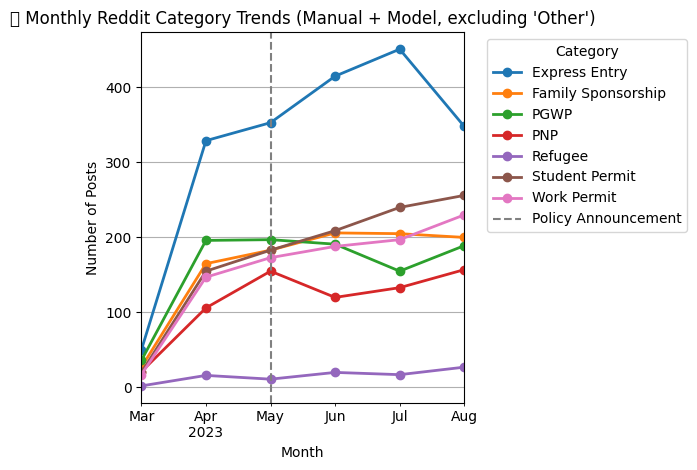

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# === 1. Load model-predicted data ===
df_model = pd.read_csv("data_with_predictions_NoSample_Clean.csv")
df_model = df_model.rename(columns={"predicted_category": "category"})
df_model["month_parsed"] = pd.to_datetime(df_model["month"], format="%y-%b", errors="coerce")
df_model = df_model[["month", "month_parsed", "category"]]

# === 2. Load manually labeled data ===
df_manual = pd.read_csv("data_with_ManualCat_Clean.csv")
df_manual = df_manual.rename(columns={"Manual_Category": "category"})
df_manual["month_parsed"] = pd.to_datetime(df_manual["month"], format="%y-%b", errors="coerce")
df_manual = df_manual[["month", "month_parsed", "category"]]

# === 3. Combine both datasets ===
df_all = pd.concat([df_model, df_manual], ignore_index=True)

# === 4. Add policy_period column ===
policy_cutoff = pd.to_datetime("2023-05-31")
df_all["policy_period"] = df_all["month_parsed"].apply(
    lambda x: "Before" if x <= policy_cutoff else "After"
)

# === 5. Save the full dataset (with 'Other') ===
df_all.to_csv("combined_data_with_policy_period.csv", index=False)
print(f"✅ Saved full dataset as 'combined_data_with_policy_period.csv'")
print(f"✅ Total combined posts: {len(df_all)}")

# === 6. Filter out 'Other' for analysis only ===
df_plot = df_all[df_all["category"] != "Other"]

# === 7. Count by month and category ===
monthly_counts = df_plot.groupby(["month_parsed", "category"]).size().unstack(fill_value=0)
monthly_counts = monthly_counts.sort_index()

# === 8. Plot with policy line ===
plt.figure(figsize=(14, 8))
monthly_counts.plot(marker='o', linewidth=2)

# ➕ Add vertical line for policy announcement
plt.axvline(datetime.datetime(2023, 5, 31), color='gray', linestyle='--', label='Policy Announcement')

# Final touches
plt.title("📈 Monthly Reddit Category Trends (Manual + Model, excluding 'Other')")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
